# Ensemble of the best models: kmeans, gaussian_mix, ward_link_opt

Try kmeans + gaussian_mix; kmeans + ward_link_opt; gaussian_mix + ward_link_opt; kmeans + gaussian_mix + ward_link_opt 

In [81]:
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist

In [82]:
df = pd.read_csv('../2_models/with_clean_data/solar/pca_df.csv')
subset_df = pd.read_csv('../2_models/with_clean_data/solar/df_subset.csv')

In [83]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

In [84]:
def dunn_index(df):
    min_intercluster_distances = []
    max_intracluster_distances = []
    for label in df['cluster_label'].unique():
        cluster_points = df[df['cluster_label'] == label][['PC1', 'PC2']]
        cluster_distances = pdist(cluster_points)
        num_clusters = min(len(df['cluster_label'].unique()), len(cluster_points))
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(cluster_points)
        min_intercluster_distances.append(min([np.linalg.norm(cluster_points.values - centroid) for centroid in kmeans.cluster_centers_]))
        if len(cluster_distances) > 0:  # Check if cluster_distances has any elements
            max_intracluster_distances.append(max(cluster_distances))
        else:
            max_intracluster_distances.append(0)  # Append a default value
    return min(min_intercluster_distances) / max(max_intracluster_distances)

In [85]:
def xie_beni_index(df):
    # Compute the total scatter
    total_scatter = np.sum(pdist(df[['PC1', 'PC2']]) ** 2) / (2 * len(df))
    
    # Compute the intra-cluster scatter
    cluster_labels = df['cluster_label'].unique()
    intra_cluster_scatter = 0
    for label in cluster_labels:
        cluster_points = df[df['cluster_label'] == label][['PC1', 'PC2']]
        cluster_center = np.mean(cluster_points, axis=0)
        intra_cluster_scatter += np.sum(np.linalg.norm(cluster_points - cluster_center, axis=1) ** 2)
    intra_cluster_scatter /= len(df)
    return intra_cluster_scatter / total_scatter

In [86]:
# Define a function to compute evaluation metrics
def compute_metrics(df):
    metrics = {}
    
    if df['cluster_label'].nunique() > 1:
        metrics['Silhouette Score'] = silhouette_score(df[['PC1', 'PC2']], df['cluster_label'])
        metrics['Davies-Bouldin Index'] = davies_bouldin_score(df[['PC1', 'PC2']], df['cluster_label'])
        metrics['Calinski-Harabasz Index'] = calinski_harabasz_score(df[['PC1', 'PC2']], df['cluster_label'])
        metrics['Dunn Index'] = dunn_index(df)
        metrics['Xie-Beni Index'] = xie_beni_index(df)
    else:
        metrics['Silhouette Score'] = 0
        metrics['Davies-Bouldin Index'] = 0
        metrics['Calinski-Harabasz Index'] = 0
        metrics['Dunn Index'] = 0
        metrics['Xie-Beni Index'] = 0

    return metrics


## K-Means + Gaussian Mix

In [87]:
# K-Means:
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans_labels = kmeans.fit_predict(df)

print('KMeans is done')

# Gaussian Mixture:
gmm = GaussianMixture(n_components=5, random_state=1, verbose=1)
gmm_labels = gmm.fit_predict(df)

KMeans is done
Initialization 0
Initialization converged: True


In [88]:
with open('results/clean_solar/gmm.pickle', 'wb') as f:
    pickle.dump(gmm, f)

with open('results/clean_solar/kmeans.pickle', 'wb') as f:
    pickle.dump(kmeans, f)

Ensemble Construction by Cluster Fusion:

Cluster Fusion: Merge clusters from K-means and GMMs based on similarity measures between cluster centroids or density distributions

In [89]:
kmeans_centroids = kmeans.cluster_centers_
gmm_centroids = gmm.means_

# Compute pairwise distances between centroids
centroid_distances = cdist(kmeans_centroids, gmm_centroids)

# Assign each K-means cluster to the most similar GMM cluster
cluster_mapping = centroid_distances.argmin(axis=1)

# Update ensemble labels based on cluster mapping
ensemble_labels = np.zeros_like(kmeans_labels)
for i, gmm_cluster in enumerate(cluster_mapping):
    ensemble_labels[kmeans_labels == i] = gmm_cluster

Ensemble Construction by Weighted Averaging:

In [90]:
df['cluster_label'] = ensemble_labels
df['asset_id'] = subset_df['asset_id']

In [91]:
df.to_csv('results/clean_solar/gmm_kmeans.csv', index = False)

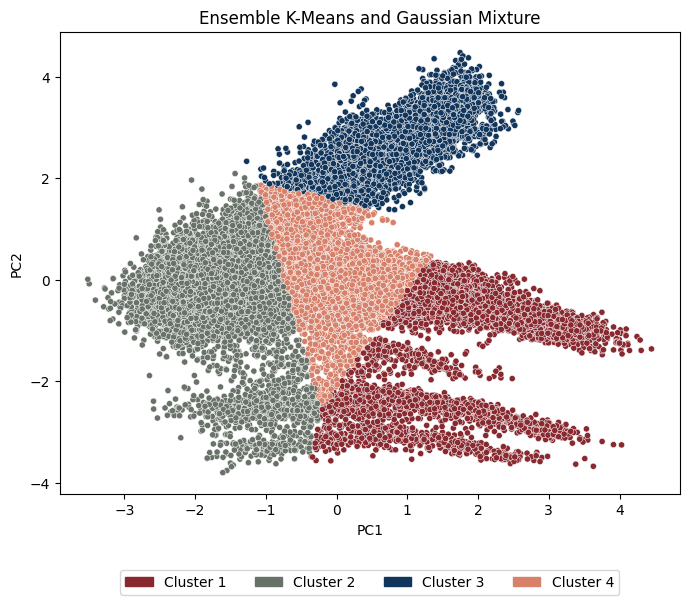

In [92]:
n_clusters = len(df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title('Ensemble K-Means and Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(ensemble_labels)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [93]:
most_frequent_clusters = df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df = df.drop(columns= 'cluster_label')

df = pd.merge(df, most_frequent_clusters, on='asset_id', how='left')

df.head()

,PC1,PC2,asset_id,cluster_label
0,0.100587,-2.352391,11,1
1,2.453818,-2.797303,11,1
2,-1.288783,-2.343181,11,1
3,1.625696,-2.561994,11,1
4,-0.847461,-2.301209,11,1


In [94]:
representative_points = df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,0.100587,-2.352391,1
1,12,-0.678988,-3.266842,1
2,13,-0.094271,-0.236147,4
3,14,1.630648,-0.165246,4
4,15,-0.194524,-0.086996,4
...,...,...,...,...
72,510,0.327813,2.326485,3
73,511,0.751870,2.981085,3
74,512,1.403833,3.298936,3
75,513,1.153314,2.070412,3


In [95]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 1: [0, 1, 33, 52, 58]
Cluster 2: [9, 10, 11, 12, 13, 14, 15, 17, 48, 49, 50, 54, 55]
Cluster 3: [36, 37, 38, 39, 40, 41, 42, 43, 44, 72, 73, 74, 75, 76]
Cluster 4: [2, 3, 4, 5, 6, 7, 8, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 45, 46, 47, 51, 53, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]


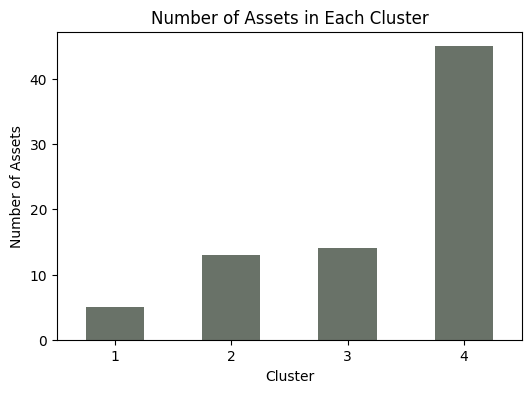

In [96]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [97]:
df = df[['PC1', 'PC2']]
df['cluster_label'] = ensemble_labels

### Metrics

In [98]:
# Initialize an empty list to store the results
results = []

# Compute and store the evaluation metrics for each dataframe
metrics = compute_metrics(df)
results.append({'Model': 'gmm + kmeans', **metrics})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

In [99]:
results_df

,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dunn Index,Xie-Beni Index
0,gmm + kmeans,0.411424,0.766063,45262.892258,10.246793,0.000011


## K-Means + Ward Link with optimized parameters

In [100]:
df = df[['PC1', 'PC2']]

In [101]:
# K-Means:
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans_labels = kmeans.fit_predict(df)

print('KMeans is done')

# Ward Link:
model_ward = AgglomerativeClustering(linkage='ward', distance_threshold=None, n_clusters=3)
ward_labels = model_ward.fit_predict(np.array(df))

KMeans is done


In [102]:
with open('results/clean_solar/ward.pickle', 'wb') as f:
    pickle.dump(model_ward, f)

Ensemble Construction by Cluster Fusion:

Cluster Fusion: Merge clusters from K-means and Ward Links based on similarity measures between cluster centroids or density distributions

In [103]:
kmeans_centroids = kmeans.cluster_centers_

ward_centroids = []
for label in np.unique(ward_labels):
    centroid = np.mean(df[ward_labels == label], axis=0)
    ward_centroids.append(centroid)

# Compute pairwise distances between centroids
centroid_distances = cdist(kmeans_centroids, ward_centroids)

# Assign each K-means cluster to the most similar WARDmodel_ward cluster
cluster_mapping = centroid_distances.argmin(axis=1)

# Update ensemble labels based on cluster mapping
ensemble_labels = np.zeros_like(kmeans_labels)
for i, model_ward_cluster in enumerate(cluster_mapping):
    ensemble_labels[kmeans_labels == i] = model_ward_cluster

In [104]:
df['cluster_label'] = ensemble_labels
df['asset_id'] = subset_df['asset_id']

In [105]:
df.to_csv('results/clean_solar/ward_kmeans.csv', index = False)

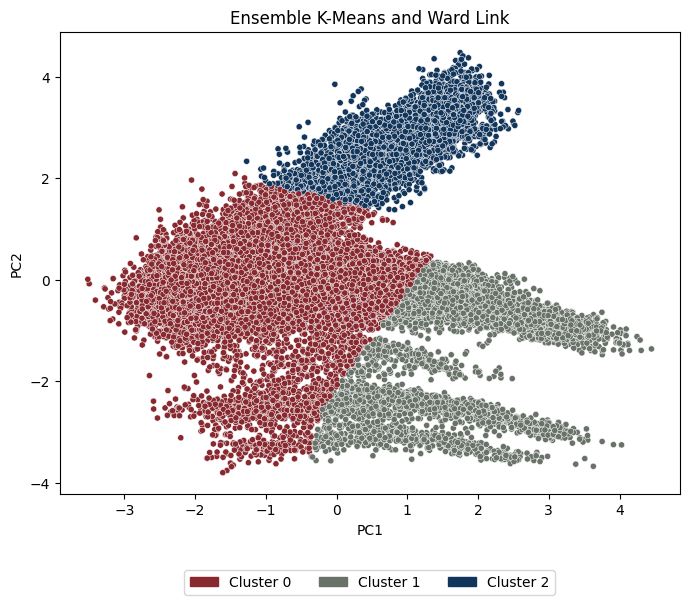

In [106]:
n_clusters = len(df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title('Ensemble K-Means and Ward Link')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(ensemble_labels)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [107]:
most_frequent_clusters = df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df = df.drop(columns= 'cluster_label')

df = pd.merge(df, most_frequent_clusters, on='asset_id', how='left')

df.head()

,PC1,PC2,asset_id,cluster_label
0,0.100587,-2.352391,11,1
1,2.453818,-2.797303,11,1
2,-1.288783,-2.343181,11,1
3,1.625696,-2.561994,11,1
4,-0.847461,-2.301209,11,1


In [108]:
representative_points = df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,0.100587,-2.352391,1
1,12,-0.678988,-3.266842,1
2,13,-0.094271,-0.236147,0
3,14,1.630648,-0.165246,0
4,15,-0.194524,-0.086996,0
...,...,...,...,...
72,510,0.327813,2.326485,0
73,511,0.751870,2.981085,2
74,512,1.403833,3.298936,0
75,513,1.153314,2.070412,0


In [109]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76]
Cluster 1: [0, 1, 52, 58]
Cluster 2: [73]


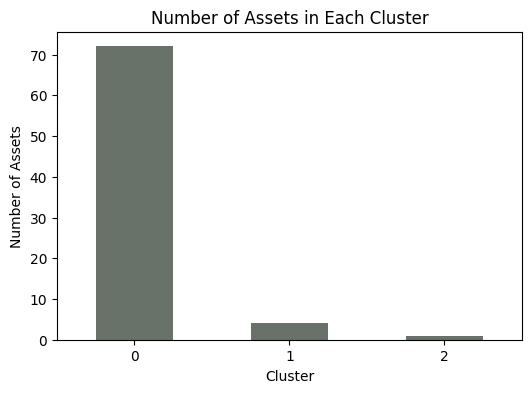

In [110]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [111]:
df = df[['PC1', 'PC2']]
df['cluster_label'] = ensemble_labels

### Metrics

In [112]:
# Compute and store the evaluation metrics for each dataframe
metrics = compute_metrics(df)
results.append({'Model': 'ward link + kmeans', **metrics})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

In [113]:
results_df

,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dunn Index,Xie-Beni Index
0,gmm + kmeans,0.411424,0.766063,45262.892258,10.246793,0.000011
1,ward link + kmeans,0.484257,0.691734,37066.177252,10.048106,0.000016


## Ward Link + Gaussian Mix

Ensemble Construction by Cluster Fusion:

Cluster Fusion: Merge clusters from K-means and GMMs based on similarity measures between cluster centroids or density distributions

In [114]:
df = df[['PC1', 'PC2']]

In [115]:
# Compute pairwise distances between centroids
centroid_distances = cdist(ward_centroids, gmm_centroids)

# Assign each K-means cluster to the most similar GMM cluster
cluster_mapping = centroid_distances.argmin(axis=1)

# Update ensemble labels based on cluster mapping
ensemble_labels = np.zeros_like(ward_labels)
for i, gmm_cluster in enumerate(cluster_mapping):
    ensemble_labels[ward_labels == i] = gmm_cluster

Ensemble Construction by Weighted Averaging:

In [116]:
df['cluster_label'] = ensemble_labels
df['asset_id'] = subset_df['asset_id']

In [117]:
df.to_csv('results/clean_solar/gmm_ward.csv', index = False)

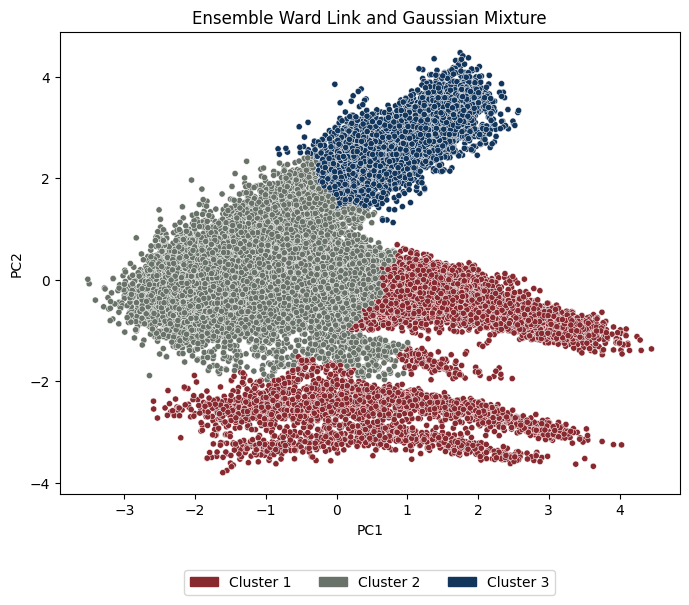

In [118]:
n_clusters = len(df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title('Ensemble Ward Link and Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(ensemble_labels)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [119]:
most_frequent_clusters = df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df = df.drop(columns= 'cluster_label')

df = pd.merge(df, most_frequent_clusters, on='asset_id', how='left')

df.head()

,PC1,PC2,asset_id,cluster_label
0,0.100587,-2.352391,11,1
1,2.453818,-2.797303,11,1
2,-1.288783,-2.343181,11,1
3,1.625696,-2.561994,11,1
4,-0.847461,-2.301209,11,1


In [120]:
representative_points = df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,0.100587,-2.352391,1
1,12,-0.678988,-3.266842,1
2,13,-0.094271,-0.236147,2
3,14,1.630648,-0.165246,2
4,15,-0.194524,-0.086996,2
...,...,...,...,...
72,510,0.327813,2.326485,2
73,511,0.751870,2.981085,3
74,512,1.403833,3.298936,2
75,513,1.153314,2.070412,2


In [121]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 1: [0, 1, 52, 58]
Cluster 2: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76]
Cluster 3: [73]


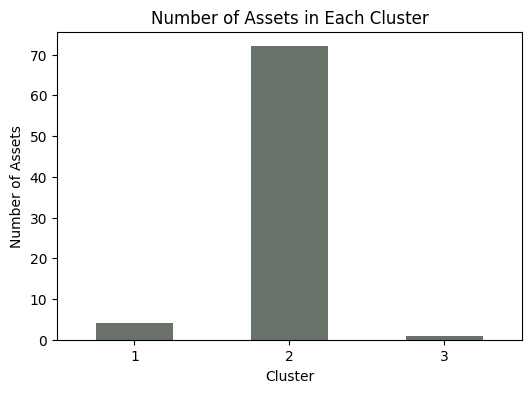

In [122]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [123]:
df = df[['PC1', 'PC2']]
df['cluster_label'] = ensemble_labels

### Metrics

In [124]:
# Compute and store the evaluation metrics for each dataframe
metrics = compute_metrics(df)
results.append({'Model': 'gmm + ward', **metrics})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

In [125]:
results_df

,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dunn Index,Xie-Beni Index
0,gmm + kmeans,0.411424,0.766063,45262.892258,10.246793,0.000011
1,ward link + kmeans,0.484257,0.691734,37066.177252,10.048106,0.000016
2,gmm + ward,0.485698,0.740179,37742.606190,7.640272,0.000016


## GMM + K-Means + Ward Link

In [126]:
df = df[['PC1', 'PC2']]

In [127]:
# K-Means:
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans_labels = kmeans.fit_predict(df)

print('KMeans is done')

# Ward Link:
model_ward = AgglomerativeClustering(linkage='ward', distance_threshold=None, n_clusters=3)
ward_labels = model_ward.fit_predict(np.array(df))

# Gaussian Mixture:
gmm = GaussianMixture(n_components=5, random_state=1, verbose=1)
gmm_labels = gmm.fit_predict(df)

KMeans is done
Initialization 0
Initialization converged: True


Ensemble Construction by Cluster Fusion:

In [128]:
# Assuming you have three clustering models: kmeans, gmm, and model_ward

# Get centroids from AgglomerativeClustering with 'ward' linkage
ward_labels = model_ward.labels_
ward_centroids = []
for label in np.unique(ward_labels):
    centroid = np.mean(df[ward_labels == label], axis=0)
    ward_centroids.append(centroid)

kmeans_centroids = kmeans.cluster_centers_
gmm_centroids = gmm.means_

# Compute pairwise distances between centroids
centroid_distances = np.zeros((len(kmeans_centroids), len(ward_centroids), len(gmm_centroids)))
for i, kmeans_centroid in enumerate(kmeans_centroids):
    for j, ward_centroid in enumerate(ward_centroids):
        for k, gmm_centroid in enumerate(gmm_centroids):
            centroid_distances[i, j, k] = np.linalg.norm(kmeans_centroid - ward_centroid) + np.linalg.norm(kmeans_centroid - gmm_centroid) + np.linalg.norm(ward_centroid - gmm_centroid)

# Assign each K-means cluster to the most similar GMM cluster
cluster_mapping = np.argmin(centroid_distances, axis=2)

# Update ensemble labels based on cluster mapping
ensemble_labels = np.zeros_like(kmeans_labels)
for i in range(len(kmeans_centroids)):
    for j, ward_cluster in enumerate(cluster_mapping[i]):
        ensemble_labels[(kmeans_labels == i) & (ward_labels == j)] = ward_cluster


In [129]:
df['cluster_label'] = ensemble_labels
df['asset_id'] = subset_df['asset_id']

In [130]:
df.to_csv('results/clean_solar/ward_kmeans_gmm.csv', index = False)

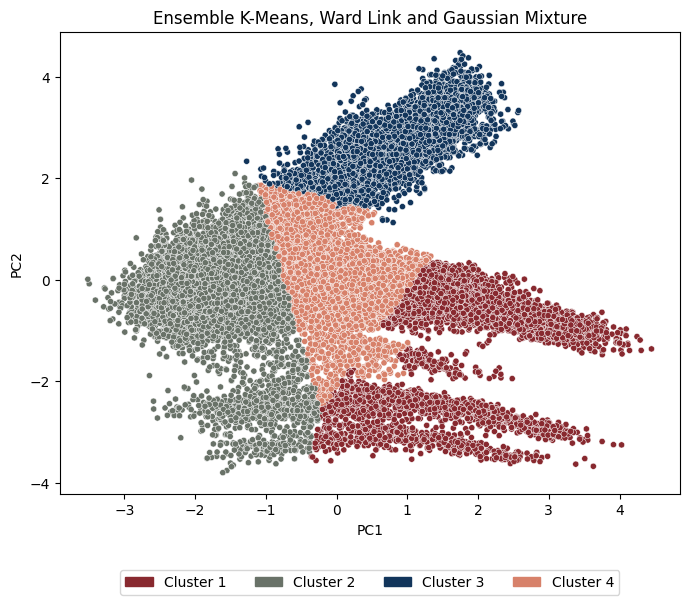

In [131]:
n_clusters = len(df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title('Ensemble K-Means, Ward Link and Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(ensemble_labels)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [132]:
most_frequent_clusters = df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df = df.drop(columns= 'cluster_label')

df = pd.merge(df, most_frequent_clusters, on='asset_id', how='left')

df.head()

,PC1,PC2,asset_id,cluster_label
0,0.100587,-2.352391,11,1
1,2.453818,-2.797303,11,1
2,-1.288783,-2.343181,11,1
3,1.625696,-2.561994,11,1
4,-0.847461,-2.301209,11,1


In [133]:
representative_points = df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,0.100587,-2.352391,1
1,12,-0.678988,-3.266842,1
2,13,-0.094271,-0.236147,4
3,14,1.630648,-0.165246,4
4,15,-0.194524,-0.086996,4
...,...,...,...,...
72,510,0.327813,2.326485,3
73,511,0.751870,2.981085,3
74,512,1.403833,3.298936,3
75,513,1.153314,2.070412,3


In [134]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 1: [0, 1, 52, 58]
Cluster 2: [9, 10, 11, 12, 13, 14, 15, 17, 48, 49, 50, 54, 55]
Cluster 3: [36, 37, 38, 39, 40, 41, 42, 43, 44, 72, 73, 74, 75, 76]
Cluster 4: [2, 3, 4, 5, 6, 7, 8, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 45, 46, 47, 51, 53, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]


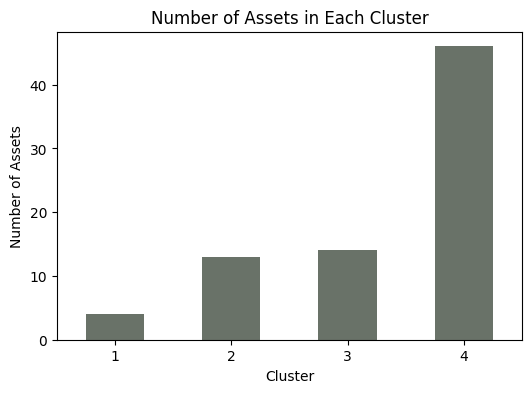

In [135]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [136]:
df = df[['PC1', 'PC2']]
df['cluster_label'] = ensemble_labels

### Metrics

In [137]:
# Compute and store the evaluation metrics for each dataframe
metrics = compute_metrics(df)
results.append({'Model': 'ward link + kmeans + gmm', **metrics})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

In [138]:
results_df

,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dunn Index,Xie-Beni Index
0,gmm + kmeans,0.411424,0.766063,45262.892258,10.246793,0.000011
1,ward link + kmeans,0.484257,0.691734,37066.177252,10.048106,0.000016
2,gmm + ward,0.485698,0.740179,37742.606190,7.640272,0.000016
3,ward link + kmeans + gmm,0.410994,0.768738,45056.777809,10.838498,0.000011


In [139]:
with open('results/clean_solar/results.pickle', 'wb') as f:
    pickle.dump(results, f)

results_df.to_csv('results/clean_solar/results.csv', index=False)